## [1. Import Needed Modules](#import) ##
## [2. Read in images and create a dataframe of image paths and class labels](#makedf) ## 
## [3. Trim train_df so each class has 500 image samples](#trim) ##
## [4. Create train, test and validation generators](#generators) ## 
## [5. Create a function to show Training Image Samples](#show) ## 
## [6. Create the Model](#model) ## 
## [7. Create a custom Keras callback to continue or halt training](#callback) ## 
## [8. Instantiate custom callback and create callbacks to control learning rate and early stopping](#callbacks) ##
## [9. Train the model](#train) ##
## [10. Define a function to plot the training data](#plot) ##
## [11. Make predictions on test set, create Confusion Matrix and Classification Report](#result) ##
## [12 Save the model](#save) ##


<a id="import"></a>
# <center>Import Need Modules</center>

In [1]:
import numpy as np
import pandas as pd
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import time
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
sns.set_style('darkgrid')
import shutil
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model
import time

<a id="makedf"></a>
# <center>Read in images and create a dataframe of image paths and class labels</center>

In [2]:
train_path=r'../input/food11/food11/train'
test_path=r'../input/food11/food11/test'
for d in [train_path, test_path]:
    filepaths = []
    labels=[] 
    classlist=os.listdir(d)   
    for klass in classlist:
        classpath=os.path.join(d, klass)
        flist=os.listdir(classpath)        
        for f in flist:
            fpath=os.path.join(classpath,f)
            filepaths.append(fpath)
            labels.append(klass)
    Fseries=pd.Series(filepaths, name='filepaths')
    Lseries=pd.Series(labels, name='labels')        
    pdf=pd.concat([Fseries, Lseries], axis=1)
    if d == test_path:
        test_df=pdf
    else:
        df=pdf
train_df, valid_df=train_test_split(df, train_size=.9, shuffle=True, random_state=123, stratify=df['labels'])    
print('train_df lenght: ', len(train_df), '  test_df length: ', len(test_df), '  valid_df length: ', len(valid_df))
# get the number of classes and the images count for each class in train_df
classes=sorted(list(train_df['labels'].unique()))
class_count = len(classes)
print('The number of classes in the dataset is: ', class_count)
groups=train_df.groupby('labels')
print('{0:^30s} {1:^13s}'.format('CLASS', 'IMAGE COUNT'))
countlist=[]
classlist=[]
for label in sorted(list(train_df['labels'].unique())):
    group=groups.get_group(label)
    countlist.append(len(group))
    classlist.append(label)
    print('{0:^30s} {1:^13s}'.format(label, str(len(group))))

# get the classes with the minimum and maximum number of train images
max_value=np.max(countlist)
max_index=countlist.index(max_value)
max_class=classlist[max_index]
min_value=np.min(countlist)
min_index=countlist.index(min_value)
min_class=classlist[min_index]
print(max_class, ' has the most images= ',max_value, ' ', min_class, ' has the least images= ', min_value)
# lets get the average height and width of a sample of the train images
ht=0
wt=0
# select 100 random samples of train_df
train_df_sample=train_df.sample(n=100, random_state=123,axis=0)
for i in range (len(train_df_sample)):
    fpath=train_df_sample['filepaths'].iloc[i]
    img=plt.imread(fpath)
    shape=img.shape
    ht += shape[0]
    wt += shape[1]
print('average height= ', ht//100, ' average width= ', wt//100, 'aspect ratio= ', ht/wt)

train_df lenght:  8910   test_df length:  1100   valid_df length:  990
The number of classes in the dataset is:  11
            CLASS               IMAGE COUNT 
          apple_pie                 810     
          cheesecake                810     
        chicken_curry               810     
         french_fries               810     
          fried_rice                810     
          hamburger                 810     
           hot_dog                  810     
          ice_cream                 810     
           omelette                 810     
            pizza                   810     
            sushi                   810     
apple_pie  has the most images=  810   apple_pie  has the least images=  810
average height=  485  average width=  485 aspect ratio=  1.0008033948582729


<a id="trim"></a>
# <center>trim train_df so each class has 300 image samples</center>


In [3]:
def trim(df, max_samples, min_samples, column):
    df=df.copy()
    groups=df.groupby(column)    
    trimmed_df = pd.DataFrame(columns = df.columns)
    groups=df.groupby(column)
    for label in df[column].unique(): 
        group=groups.get_group(label)
        count=len(group)    
        if count > max_samples:
            sampled_group=group.sample(n=max_samples, random_state=123,axis=0)
            trimmed_df=pd.concat([trimmed_df, sampled_group], axis=0)
        else:
            if count>=min_samples:
                sampled_group=group        
                trimmed_df=pd.concat([trimmed_df, sampled_group], axis=0)
    print('after trimming, the maximum samples in any class is now ',max_samples, ' and the minimum samples in any class is ', min_samples)
    return trimmed_df

max_samples=300 # since each class has more than 200 images all classes will be trimmed to have 200 images per class
min_samples=300
column='labels'
train_df= trim(train_df, max_samples, min_samples, column)

after trimming, the maximum samples in any class is now  300  and the minimum samples in any class is  300


<a id="generators"></a>
# <center>Create the train_gen, test_gen final_test_gen and valid_gen</center>

In [4]:
working_dir=r'./'
img_size=(256,256)
batch_size=20 # We will use and EfficientetB3 model, with image size of (200, 250) this size should not cause resource error
trgen=ImageDataGenerator(horizontal_flip=True,rotation_range=20, width_shift_range=.2,
                                  height_shift_range=.2, zoom_range=.2 )
t_and_v_gen=ImageDataGenerator()
msg='{0:70s} for train generator'.format(' ')
print(msg, '\r', end='') # prints over on the same line
train_gen=trgen.flow_from_dataframe(train_df, x_col='filepaths', y_col='labels', target_size=img_size,
                                   class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=batch_size)
msg='{0:70s} for valid generator'.format(' ')
print(msg, '\r', end='') # prints over on the same line
valid_gen=t_and_v_gen.flow_from_dataframe(valid_df, x_col='filepaths', y_col='labels', target_size=img_size,
                                   class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=batch_size)
# for the test_gen we want to calculate the batch size and test steps such that batch_size X test_steps= number of samples in test set
# this insures that we go through all the sample in the test set exactly once.
length=len(test_df)
test_batch_size=sorted([int(length/n) for n in range(1,length+1) if length % n ==0 and length/n<=80],reverse=True)[0]  
test_steps=int(length/test_batch_size)
msg='{0:70s} for test generator'.format(' ')
print(msg, '\r', end='') # prints over on the same line
test_gen=t_and_v_gen.flow_from_dataframe(test_df, x_col='filepaths', y_col='labels', target_size=img_size,
                                   class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=test_batch_size)
# from the generator we can get information we will need later
classes=list(train_gen.class_indices.keys())
class_indices=list(train_gen.class_indices.values())
class_count=len(classes)
labels=test_gen.labels
print ( 'test batch size: ' ,test_batch_size, '  test steps: ', test_steps, ' number of classes : ', class_count)

Found 3300 validated image filenames belonging to 11 classes.          for train generator 
Found 990 validated image filenames belonging to 11 classes.           for valid generator 
Found 1100 validated image filenames belonging to 11 classes.          for test generator 
test batch size:  55   test steps:  20  number of classes :  11


<a id="show"></a>
# <center>Create a function to show example training images</center>

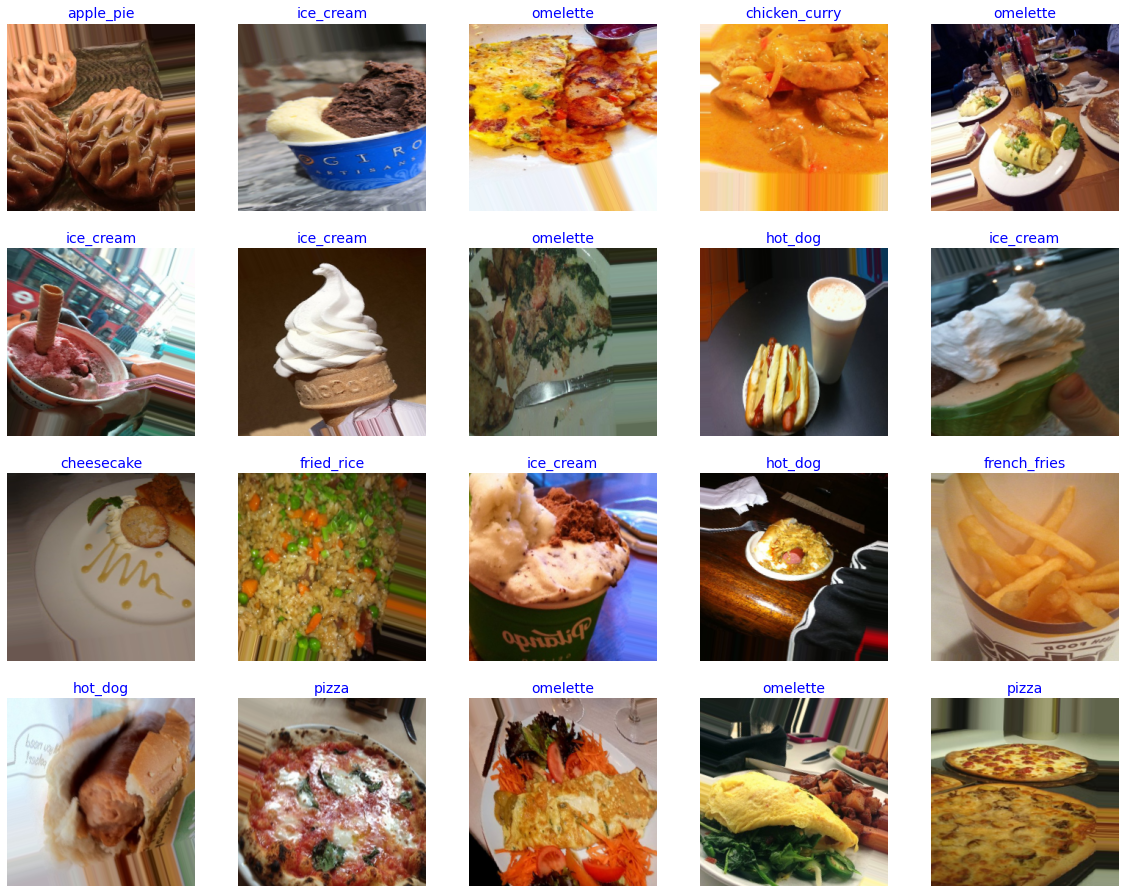

In [5]:
def show_image_samples(gen ):
    t_dict=gen.class_indices
    classes=list(t_dict.keys())    
    images,labels=next(gen) # get a sample batch from the generator 
    plt.figure(figsize=(20, 20))
    length=len(labels)
    if length<25:   #show maximum of 25 images
        r=length
    else:
        r=25
    for i in range(r):        
        plt.subplot(5, 5, i + 1)
        image=images[i] /255       
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color='blue', fontsize=14)
        plt.axis('off')
    plt.show()
    
show_image_samples(train_gen )

<a id="model"></a>
# <center>Create a model using transfer learning with EfficientNetB3</center>
### NOTE experts advise you make the base model initially not trainable. Then train for some number of epochs
### then fine tune model by making base model trainable and run more epochs
### I have found this to be WRONG!!!!
### Making the base model trainable from the outset leads to faster convegence and a lower validation loss
### for the same number of total epochs!

In [6]:
img_shape=(img_size[0], img_size[1], 3)
model_name='EfficientNetB3'
base_model=tf.keras.applications.efficientnet.EfficientNetB3(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max') 
# Note you are always told NOT to make the base model trainable initially- that is WRONG you get better results leaving it trainable
base_model.trainable=True
x=base_model.output
x=BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)
x = Dense(256, kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer=regularizers.l1(0.006),
                bias_regularizer=regularizers.l1(0.006) ,activation='relu')(x)
x=Dropout(rate=.4, seed=123)(x)       
output=Dense(class_count, activation='softmax')(x)
model=Model(inputs=base_model.input, outputs=output)
lr=.001 # start with this learning rate
model.compile(Adamax(learning_rate=lr), loss='categorical_crossentropy', metrics=['accuracy']) 

43950080/43941136 [==============================] - 0s 0us/step


<a id="callback"></a>
# <center>Create a custom Keras callback to continue and optionally set LR or halt training</center>
The LR_ASK callback is a convenient callback that allows you to continue training for ask_epoch more epochs or to halt training.  
If you elect to continue training for more epochs you are given the option to retain the current learning rate (LR) or to  
enter a new value for the learning rate. The form of use is:  
ask=LR_ASK(model,epochs, ask_epoch) where:  
* model is a string which is the name of your compiled model
* epochs is an integer which is the number of epochs to run specified in model.fit
* ask_epoch is an integer. If ask_epoch is set to a value say 5 then the model will train for 5 epochs.  
  then the user is ask to enter H to halt training, or enter an inter value. For example if you enter 4  
  training will continue for 4 more epochs to epoch 9 then you will be queried again. Once you enter an  
  integer value you are prompted to press ENTER to continue training using the current learning rate  
  or to enter a new value for the learning rate.  
  
 At the end of training the model weights are set to the weights for the epoch that achieved the lowest validation loss

In [7]:
class LR_ASK(keras.callbacks.Callback):
    def __init__ (self, model, epochs,  ask_epoch): # initialization of the callback
        super(LR_ASK, self).__init__()
        self.model=model               
        self.ask_epoch=ask_epoch
        self.epochs=epochs
        self.ask=True # if True query the user on a specified epoch
        self.lowest_vloss=np.inf
        self.best_weights=self.model.get_weights() # set best weights to model's initial weights
        self.best_epoch=1
        
        
    def on_train_begin(self, logs=None): # this runs on the beginning of training
        if self.ask_epoch == 0: 
            print('you set ask_epoch = 0, ask_epoch will be set to 1', flush=True)
            self.ask_epoch=1
        if self.ask_epoch >= self.epochs: # you are running for epochs but ask_epoch>epochs
            print('ask_epoch >= epochs, will train for ', epochs, ' epochs', flush=True)
            self.ask=False # do not query the user
        if self.epochs == 1:
            self.ask=False # running only for 1 epoch so do not query user
        else:
            print('Training will proceed until epoch', ask_epoch,' then you will be asked to') 
            print(' enter H to halt training or enter an integer for how many more epochs to run then be asked again')  
        self.start_time= time.time() # set the time at which training started
        
    def on_train_end(self, logs=None):   # runs at the end of training  
        print('loading model with weights from epoch ', self.best_epoch)
        self.model.set_weights(self.best_weights) # set the weights of the model to the best weights
        tr_duration=time.time() - self.start_time   # determine how long the training cycle lasted         
        hours = tr_duration // 3600
        minutes = (tr_duration - (hours * 3600)) // 60
        seconds = tr_duration - ((hours * 3600) + (minutes * 60))
        msg = f'training elapsed time was {str(hours)} hours, {minutes:4.1f} minutes, {seconds:4.2f} seconds)'
        print (msg, flush=True) # print out training duration time
        
    def on_epoch_end(self, epoch, logs=None):  # method runs on the end of each epoch
        v_loss=logs.get('val_loss')  # get the validation loss for this epoch
        if v_loss< self.lowest_vloss:
            self.lowest_vloss=v_loss
            self.best_weights=self.model.get_weights() # set best weights to model's initial weights
            self.best_epoch=epoch + 1
            print (f'\n validation loss of {v_loss:7.4f} is below lowest loss, saving weights from epoch {str(epoch + 1):3s} as best weights')
        else:
            print (f'\n validation loss of {v_loss:7.4f} is above lowest loss of {self.lowest_vloss:7.4f} keeping weights from epoch {str(self.best_epoch)} as best weights')
        
        if self.ask: # are the conditions right to query the user?
            if epoch + 1 ==self.ask_epoch: # is this epoch the one for quering the user?
                print('\n Enter H to end training or  an integer for the number of additional epochs to run then ask again')
                ans=input()
                
                if ans == 'H' or ans =='h' or ans == '0': # quit training for these conditions
                    print ('you entered ', ans, ' Training halted on epoch ', epoch+1, ' due to user input\n', flush=True)
                    self.model.stop_training = True # halt training
                else: # user wants to continue training
                    self.ask_epoch += int(ans)
                    if self.ask_epoch > self.epochs:
                        print('\nYou specified maximum epochs of as ', self.epochs, ' cannot train for ', self.ask_epoch, flush =True)
                    else:
                        print ('you entered ', ans, ' Training will continue to epoch ', self.ask_epoch, flush=True)
                        lr=float(tf.keras.backend.get_value(self.model.optimizer.lr)) # get the current learning rate
                        print(f'current LR is  {lr:7.5f}  hit enter to keep  this LR or enter a new LR')
                        ans=input(' ')
                        if ans =='':
                            print (f'keeping current LR of {lr:7.5f}')
                        else:
                            new_lr=float(ans)
                            tf.keras.backend.set_value(self.model.optimizer.lr, new_lr) # set the learning rate in the optimizer
                            print(' changing LR to ', ans)

<a id="callbacks"></a>
# <center>Instantiate custom callback 

In [8]:
epochs=40
ask_epoch=5
ask=LR_ASK(model, epochs,  ask_epoch)
#rlronp=tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2,verbose=1)
#callbacks=[rlronp, ask]
callbacks=[ask]

<a id="train"></a>
# <center>Train the model
### Note unlike how you are told it is BETTER to make the base model trainable from the outset
### It will converge faster and have a lower validation losss

In [9]:
history=model.fit(x=train_gen,  epochs=epochs, verbose=1, callbacks=callbacks,  validation_data=valid_gen,
               validation_steps=None,  shuffle=False,  initial_epoch=0)

Training will proceed until epoch 5  then you will be asked to
 enter H to halt training or enter an integer for how many more epochs to run then be asked again
Epoch 1/40
165/165 [==============================] - 121s 613ms/step - loss: 8.4347 - accuracy: 0.5530 - val_loss: 6.9044 - val_accuracy: 0.7788

 validation loss of  6.9044 is below lowest loss, saving weights from epoch 1   as best weights
Epoch 2/40
165/165 [==============================] - 85s 513ms/step - loss: 6.1024 - accuracy: 0.7803 - val_loss: 5.2975 - val_accuracy: 0.8394

 validation loss of  5.2975 is below lowest loss, saving weights from epoch 2   as best weights
Epoch 3/40
165/165 [==============================] - 85s 517ms/step - loss: 4.6329 - accuracy: 0.8548 - val_loss: 4.0702 - val_accuracy: 0.8717

 validation loss of  4.0702 is below lowest loss, saving weights from epoch 3   as best weights
Epoch 4/40
165/165 [==============================] - 85s 515ms/step - loss: 3.5160 - accuracy: 0.8891 - val_los

 5


you entered  5  Training will continue to epoch  10
current LR is  0.00100  hit enter to keep  this LR or enter a new LR


  0.01


 changing LR to  0.01
Epoch 6/40
165/165 [==============================] - 85s 511ms/step - loss: 4.0703 - accuracy: 0.2661 - val_loss: 60.4886 - val_accuracy: 0.0980

 validation loss of 60.4886 is above lowest loss of  2.4056 keeping weights from epoch 5 as best weights
Epoch 7/40
165/165 [==============================] - 85s 513ms/step - loss: 2.5409 - accuracy: 0.2812 - val_loss: 2.5797 - val_accuracy: 0.2071

 validation loss of  2.5797 is above lowest loss of  2.4056 keeping weights from epoch 5 as best weights
Epoch 8/40
165/165 [==============================] - 85s 513ms/step - loss: 2.2722 - accuracy: 0.3545 - val_loss: 2.7660 - val_accuracy: 0.2111

 validation loss of  2.7660 is above lowest loss of  2.4056 keeping weights from epoch 5 as best weights
Epoch 9/40
165/165 [==============================] - 83s 505ms/step - loss: 2.1780 - accuracy: 0.3976 - val_loss: 2.4695 - val_accuracy: 0.2889

 validation loss of  2.4695 is above lowest loss of  2.4056 keeping weights fr

 10


you entered  10  Training will continue to epoch  20
current LR is  0.01000  hit enter to keep  this LR or enter a new LR


  .001


 changing LR to  .001
Epoch 11/40
165/165 [==============================] - 86s 518ms/step - loss: 1.8712 - accuracy: 0.5273 - val_loss: 1.5503 - val_accuracy: 0.6323

 validation loss of  1.5503 is below lowest loss, saving weights from epoch 11  as best weights
Epoch 12/40
165/165 [==============================] - 85s 512ms/step - loss: 1.6125 - accuracy: 0.6048 - val_loss: 1.4261 - val_accuracy: 0.6606

 validation loss of  1.4261 is below lowest loss, saving weights from epoch 12  as best weights
Epoch 13/40
165/165 [==============================] - 85s 512ms/step - loss: 1.4387 - accuracy: 0.6627 - val_loss: 1.2796 - val_accuracy: 0.7010

 validation loss of  1.2796 is below lowest loss, saving weights from epoch 13  as best weights
Epoch 14/40
165/165 [==============================] - 84s 510ms/step - loss: 1.3147 - accuracy: 0.6915 - val_loss: 1.2064 - val_accuracy: 0.7253

 validation loss of  1.2064 is below lowest loss, saving weights from epoch 14  as best weights
Epoch 

 20


you entered  20  Training will continue to epoch  40
current LR is  0.00100  hit enter to keep  this LR or enter a new LR


  .001


 changing LR to  .001
Epoch 21/40
165/165 [==============================] - 85s 514ms/step - loss: 0.8405 - accuracy: 0.8461 - val_loss: 1.0344 - val_accuracy: 0.7778

 validation loss of  1.0344 is above lowest loss of  0.9918 keeping weights from epoch 20 as best weights
Epoch 22/40
165/165 [==============================] - 84s 507ms/step - loss: 0.8147 - accuracy: 0.8452 - val_loss: 0.9504 - val_accuracy: 0.8101

 validation loss of  0.9504 is below lowest loss, saving weights from epoch 22  as best weights
Epoch 23/40
165/165 [==============================] - 84s 509ms/step - loss: 0.7652 - accuracy: 0.8606 - val_loss: 0.9475 - val_accuracy: 0.8051

 validation loss of  0.9475 is below lowest loss, saving weights from epoch 23  as best weights
Epoch 24/40
165/165 [==============================] - 84s 506ms/step - loss: 0.7153 - accuracy: 0.8745 - val_loss: 0.9000 - val_accuracy: 0.8202

 validation loss of  0.9000 is below lowest loss, saving weights from epoch 24  as best weig

 H


you entered  H  Training halted on epoch  40  due to user input

loading model with weights from epoch  37
training elapsed time was 1.0 hours, 39.0 minutes, 3.72 seconds)


<a id="plot"></a>
# <center>Define a function to plot the training data

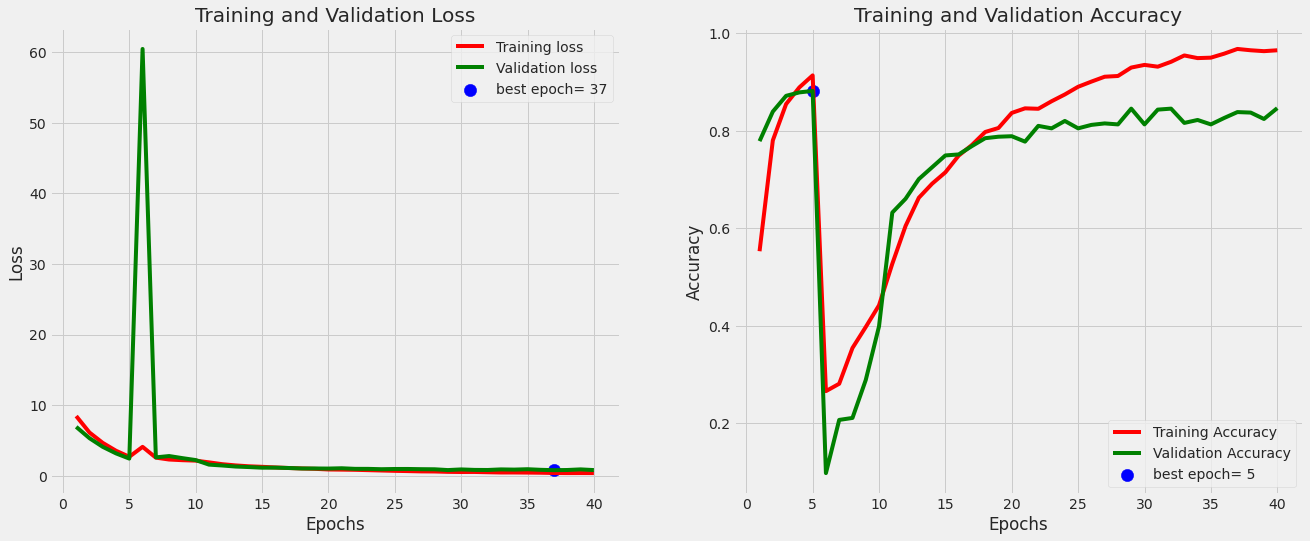

In [10]:
def tr_plot(tr_data, start_epoch):
    #Plot the training and validation data
    tacc=tr_data.history['accuracy']
    tloss=tr_data.history['loss']
    vacc=tr_data.history['val_accuracy']
    vloss=tr_data.history['val_loss']
    Epoch_count=len(tacc)+ start_epoch
    Epochs=[]
    for i in range (start_epoch ,Epoch_count):
        Epochs.append(i+1)   
    index_loss=np.argmin(vloss)#  this is the epoch with the lowest validation loss
    val_lowest=vloss[index_loss]
    index_acc=np.argmax(vacc)
    acc_highest=vacc[index_acc]
    plt.style.use('fivethirtyeight')
    sc_label='best epoch= '+ str(index_loss+1 +start_epoch)
    vc_label='best epoch= '+ str(index_acc + 1+ start_epoch)
    fig,axes=plt.subplots(nrows=1, ncols=2, figsize=(20,8))
    axes[0].plot(Epochs,tloss, 'r', label='Training loss')
    axes[0].plot(Epochs,vloss,'g',label='Validation loss' )
    axes[0].scatter(index_loss+1 +start_epoch,val_lowest, s=150, c= 'blue', label=sc_label)
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[1].plot (Epochs,tacc,'r',label= 'Training Accuracy')
    axes[1].plot (Epochs,vacc,'g',label= 'Validation Accuracy')
    axes[1].scatter(index_acc+1 +start_epoch,acc_highest, s=150, c= 'blue', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    plt.tight_layout    
    plt.show()
    
tr_plot(history,0)

<a id="result"></a>
# <center>Make Predictions on the test set</a>
### Define a function which takes in a test generator and an integer test_steps
### and generates predictions on the test set including a confusion matric
### and a classification report

20/20 [==============================] - 16s 678ms/step
there were 178 errors in 1100 tests for an accuracy of  83.82


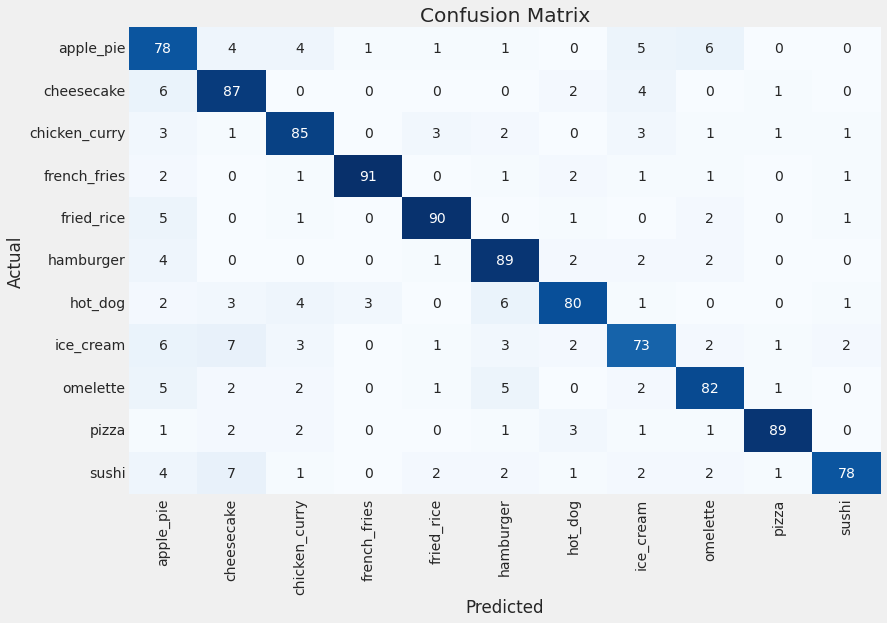

Classification Report:
----------------------
                precision    recall  f1-score   support

    apple_pie     0.6724    0.7800    0.7222       100
   cheesecake     0.7699    0.8700    0.8169       100
chicken_curry     0.8252    0.8500    0.8374       100
 french_fries     0.9579    0.9100    0.9333       100
   fried_rice     0.9091    0.9000    0.9045       100
    hamburger     0.8091    0.8900    0.8476       100
      hot_dog     0.8602    0.8000    0.8290       100
    ice_cream     0.7766    0.7300    0.7526       100
     omelette     0.8283    0.8200    0.8241       100
        pizza     0.9468    0.8900    0.9175       100
        sushi     0.9286    0.7800    0.8478       100

     accuracy                         0.8382      1100
    macro avg     0.8440    0.8382    0.8394      1100
 weighted avg     0.8440    0.8382    0.8394      1100



In [11]:
def predictor(test_gen, test_steps):
    y_pred= []
    y_true=test_gen.labels
    classes=list(test_gen.class_indices.keys())
    class_count=len(classes)
    errors=0
    preds=model.predict(test_gen, verbose=1)
    tests=len(preds)    
    for i, p in enumerate(preds):        
        pred_index=np.argmax(p)         
        true_index=test_gen.labels[i]  # labels are integer values        
        if pred_index != true_index: # a misclassification has occurred                                           
            errors=errors + 1
            file=test_gen.filenames[i]            
        y_pred.append(pred_index)
            
    acc=( 1-errors/tests) * 100
    print(f'there were {errors} errors in {tests} tests for an accuracy of {acc:6.2f}')
    ypred=np.array(y_pred)
    ytrue=np.array(y_true)
    if class_count <=30:
        cm = confusion_matrix(ytrue, ypred )
        # plot the confusion matrix
        plt.figure(figsize=(12, 8))
        sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)       
        plt.xticks(np.arange(class_count)+.5, classes, rotation=90)
        plt.yticks(np.arange(class_count)+.5, classes, rotation=0)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()
    clr = classification_report(y_true, y_pred, target_names=classes, digits= 4) # create classification report
    print("Classification Report:\n----------------------\n", clr)
    return errors, tests
errors, tests=predictor(test_gen, test_steps)

<a id="save"></a>
# <center>Save the model

In [12]:
subject='maskss' 
acc=str(( 1-errors/tests) * 100)
index=acc.rfind('.')
acc=acc[:index + 3]
save_id= subject + '_' + str(acc) + '.h5' 
model_save_loc=os.path.join(working_dir, save_id)
model.save(model_save_loc)
print ('model was saved as ' , model_save_loc ) 
   

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


model was saved as  ./maskss_83.81.h5


In [13]:
pip install pyyaml h5py

Note: you may need to restart the kernel to use updated packages.


In [14]:
model.save("pretrained_custom_model.h5py")

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [15]:
!zip -r file.zip /kaggle/working/

  adding: kaggle/working/ (stored 0%)
  adding: kaggle/working/.virtual_documents/ (stored 0%)
  adding: kaggle/working/pretrained_custom_model.h5py/ (stored 0%)
  adding: kaggle/working/pretrained_custom_model.h5py/variables/ (stored 0%)
  adding: kaggle/working/pretrained_custom_model.h5py/variables/variables.data-00000-of-00001 (deflated 8%)
  adding: kaggle/working/pretrained_custom_model.h5py/variables/variables.index (deflated 79%)
  adding: kaggle/working/pretrained_custom_model.h5py/keras_metadata.pb (deflated 96%)
  adding: kaggle/working/pretrained_custom_model.h5py/assets/ (stored 0%)
  adding: kaggle/working/pretrained_custom_model.h5py/saved_model.pb (deflated 92%)
  adding: kaggle/working/maskss_83.81.h5 (deflated 9%)
  adding: kaggle/working/__notebook_source__.ipynb (deflated 44%)


In [16]:
model.save_weights('Pretrained_CNNFoodClassificationModel.h5')

In [25]:
import numpy as np
from keras.preprocessing import image

test_image = image.load_img(
    '/kaggle/input/food11/food11/test/apple_pie/118237.jpg',
    target_size=(256, 256))
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis=0)
result = model.predict(test_image)
result

array([[9.9968874e-01, 3.6989961e-05, 5.1238454e-05, 6.7469746e-06,
        8.7599165e-06, 4.8751423e-05, 1.5436277e-05, 7.8996469e-05,
        5.1082086e-05, 5.0547301e-06, 8.2138831e-06]], dtype=float32)

In [26]:
output = {0:'apple_pie', 1:'cheesecake', 2:'chicken_curry', 3:'french_fries',
 4:'fried_rice', 5:'hamburger', 6:'hot_dog', 7:'ice_cream', 8:'omelette',
 9:'pizza', 10:'sushi'}
print(output[np.argmax(result)])

apple_pie
